In [1]:
!pip install ipympl


In [2]:
%matplotlib notebook 
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)   # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Tanh()       # Output a value between 0 and 1
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x = self.decoder(x_encoded)
        return x, x_encoded

In [4]:
# Load and transform the dataset
# 데이터를 파이토치 텐서로 바꿔주는 부분
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
# Load the train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# mini batch gradient descent
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)  # Larger batch size for testing

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
# 경사하강법 같이 역전파로 구한 가중치들의 변화를 업데이트 해주는 역할
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        # 1차원 즉, 784(28*28)로 바꾸어줌, 실제로는 미니배치가 있기때문에 (32, 784)임
        img = img.view(img.size(0), -1)  # Flatten the images
        output,_ = model(img)
        # MSE를 사용하여 손실 구함
        loss = criterion(output, img)

        optimizer.zero_grad()
        # 역전파 구함, 파이토치를 사용하니까, 일일이 가중치를 구하지 않고도 간단하게 한줄의 코드로 역전파를 구할수있음, 
        loss.backward()
        # 그다음 옵티마이저(경사하강법)을 사용하여 각각의 가중치를 업데이트 해줌
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training Complete")

Epoch [1/20], Loss: 0.0434
Epoch [2/20], Loss: 0.0341
Epoch [3/20], Loss: 0.0389
Epoch [4/20], Loss: 0.0403
Epoch [5/20], Loss: 0.0343
Epoch [6/20], Loss: 0.0392
Epoch [7/20], Loss: 0.0337
Epoch [8/20], Loss: 0.0356
Epoch [9/20], Loss: 0.0368
Epoch [10/20], Loss: 0.0358
Epoch [11/20], Loss: 0.0387
Epoch [12/20], Loss: 0.0390
Epoch [13/20], Loss: 0.0306
Epoch [14/20], Loss: 0.0318
Epoch [15/20], Loss: 0.0330
Epoch [16/20], Loss: 0.0343
Epoch [17/20], Loss: 0.0334
Epoch [18/20], Loss: 0.0312
Epoch [19/20], Loss: 0.0313
Epoch [20/20], Loss: 0.0314
Training Complete


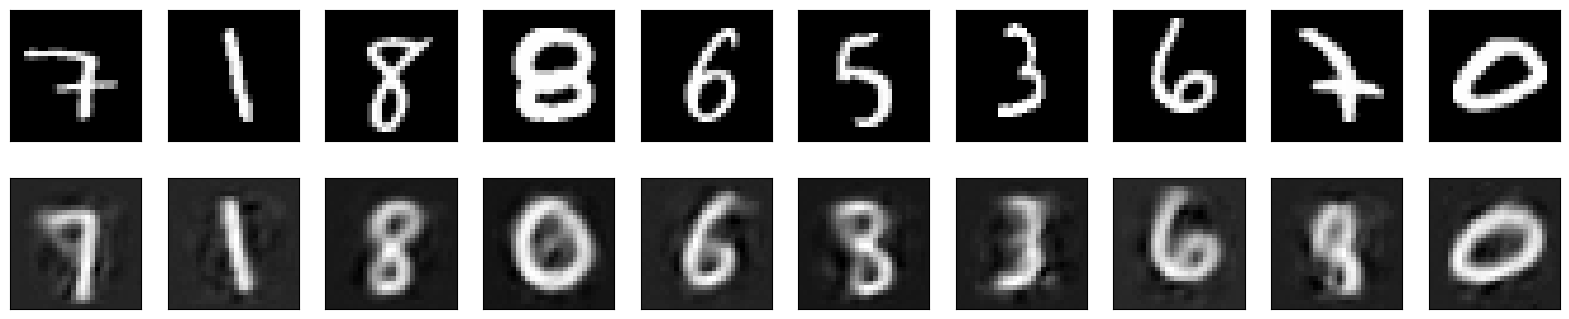

In [7]:
# Testing the model and visualizing some results
# Get a batch of data
dataiter = iter(test_loader)
images, _ = next(dataiter)
images_flattened = images.view(images.size(0), -1)

# Forward pass the images through the autoencoder
output, _ = model(images_flattened)
output = output.view(output.size(0), 1, 28, 28).detach()

# Visualize the results
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# Original images
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

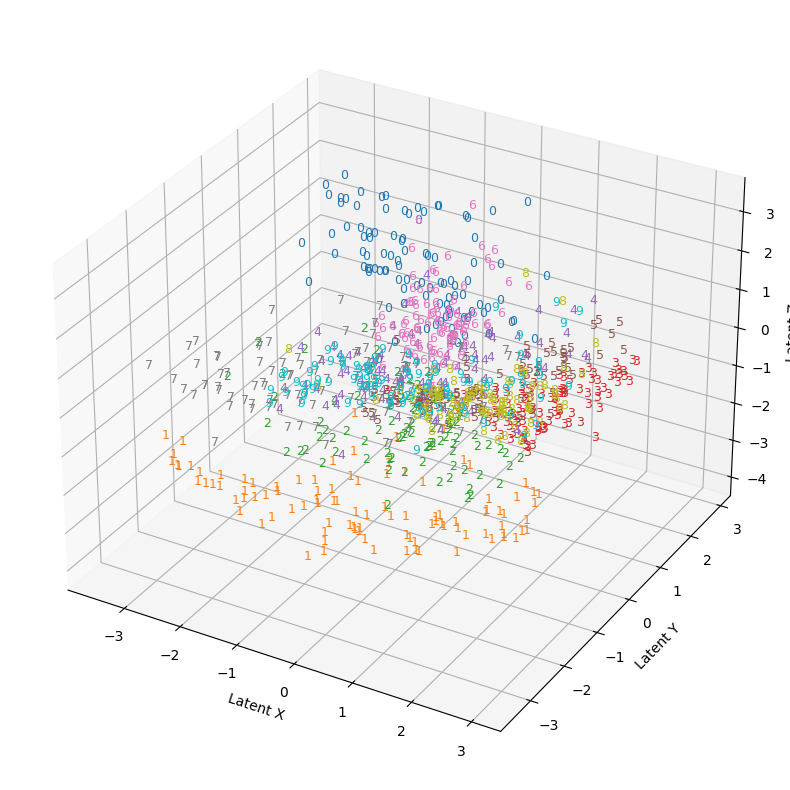

In [8]:
# Testing the model and collecting latent vectors
model.eval()  # Set the model to evaluation mode

latent_vectors = []
labels = []

with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data
        imgs = imgs.view(imgs.size(0), -1)
        _, latents = model(imgs)
        latent_vectors.append(latents)
        labels.append(lbls)

latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

# 3D Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Annotate a subset of points from each label category
for i in range(10):
    indices = np.where(labels == i)[0]
    subset_indices = np.random.choice(indices, size=min(len(indices), 100), replace=False)

    for idx in subset_indices:
        ax.text(latent_vectors[idx, 0].item(), latent_vectors[idx, 1].item(), latent_vectors[idx, 2].item(),
                str(i), color=plt.cm.tab10(i), fontsize=9, ha='center')


# Setting axis limits based on the data range
x_min, x_max = latent_vectors[:, 0].min(), latent_vectors[:, 0].max()
y_min, y_max = latent_vectors[:, 1].min(), latent_vectors[:, 1].max()
z_min, z_max = latent_vectors[:, 2].min(), latent_vectors[:, 2].max()

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)


ax.set_xlabel('Latent X')
ax.set_ylabel('Latent Y')
ax.set_zlabel('Latent Z')

plt.show()